                                                     Assignment 2

                                              Team Members - 
                                              1. Ganesh Nimkar (K00277641)
                                              2. Sanket Sangar (K00277641)

# Introduction 

In this assignment, we are using data from public API exposed by JCDecaux (https://developer.jcdecaux.com/#/opendata/vls?page=getstarted). This is real time bike data that we are storing in .db file using python's sqlite library. We have used two API's to collect the data. One API gets the list of contracts. We use data from the contracts API to call /stations API to get the data of all stations from current contract. 

# Plan

Looking at the data, we had drawn a plan - 
#### Clean the data -
1. Remove duplicates - The timestamp and name of the stations makes the composite key for given table. We can use this two fields to remove the duplicate rows to avoid further miscalculations. 
2.We have noticied that some of the columns have JSON data. So we need to move this data out of the cell and store it in new column.  

#### Analysis - 
   - In analysis part, we have focused on below points 
        - Calculate how many bikes are in use at given timestamp 
        - get maximum capacity station by country
        - Average use of bike service per country 
        - Average use of different types of bike by country and city
      
   We did time series analysis to find out patterns in bike use according to time of the day. We have recorded analysis for Ireland, France and Japan. 


### Import essential libraries



In [140]:
import pandas as pd
import numpy as np
import sqlite3
import datetime

### Load the data

In next step, we will load the data that we are collected and stored in bike.db file. 
using sqlite3, we connect to bike.db file and open the connection first. Then we use the cursor to execute the queries on database table. 
In our case, the table name is "bikesdata"

In [142]:
# Create connection to database
con = sqlite3.connect("../bike.db")
cur = con.cursor()

# Select all data
cur.execute("SELECT * From bikesdata")

# Store all fetched data in a list
data = cur.fetchall()
con.close()

Now we have stored all the "bikesdata" table data in "Data" variable. Now we can create a data frame using Panda library. 
After converting data to dataframe, we can see some records from dataframe using head()

In [168]:
# Create a pandas dataframe from this list
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,5,rouen,05- HOTEL DE VILLE,RUE DE L HOPITAL,"{""latitude"": 49.44250558644192, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:15:29Z,1,0,"{""availabilities"": {""bikes"": 15, ""stands"": 5, ...","{""availabilities"": {""bikes"": 15, ""stands"": 5, ...",null,FR
1,14,rouen,14- BALZAC - BOULEVARD DE L' EUROPE,BOULEVARD DE L' EUROPE,"{""latitude"": 49.42582345143276, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:08:21Z,1,0,"{""availabilities"": {""bikes"": 17, ""stands"": 8, ...","{""availabilities"": {""bikes"": 17, ""stands"": 8, ...",null,FR
2,10,rouen,10- PLACE CARNOT,COURS CLEMENCEAU,"{""latitude"": 49.4336973759198, ""longitude"": 1....",1,0,OPEN,2022-04-29T23:16:29Z,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 10, ...","{""availabilities"": {""bikes"": 5, ""stands"": 10, ...",null,FR
3,20,rouen,20 - AUBERGE DE JEUNESSE,ROUTE DE DARNETAL,"{""latitude"": 49.441452231089485, ""longitude"": ...",1,0,OPEN,2022-04-29T23:13:43Z,1,0,"{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...","{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...",null,FR
4,17,rouen,17- SAINT CLEMENT,RUE LECUYER ANGLE RUE LETHUILLIER PINEL,"{""latitude"": 49.42576540125409, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:13:08Z,1,0,"{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...","{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...",null,FR


As you can see above, the columns names are not in correct format. So in next step, we will change the column names. 

In [169]:
df.columns=["number","contractName","name","address", "position","banking", "bonus", "status", "lastUpdated", "connected", "overflow", "totalStands", "mainStands", "overflowStands", "country_code"]
df.head()

,number,contractName,name,address,position,banking,bonus,status,lastUpdated,connected,overflow,totalStands,mainStands,overflowStands,country_code
0,5,rouen,05- HOTEL DE VILLE,RUE DE L HOPITAL,"{""latitude"": 49.44250558644192, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:15:29Z,1,0,"{""availabilities"": {""bikes"": 15, ""stands"": 5, ...","{""availabilities"": {""bikes"": 15, ""stands"": 5, ...",null,FR
1,14,rouen,14- BALZAC - BOULEVARD DE L' EUROPE,BOULEVARD DE L' EUROPE,"{""latitude"": 49.42582345143276, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:08:21Z,1,0,"{""availabilities"": {""bikes"": 17, ""stands"": 8, ...","{""availabilities"": {""bikes"": 17, ""stands"": 8, ...",null,FR
2,10,rouen,10- PLACE CARNOT,COURS CLEMENCEAU,"{""latitude"": 49.4336973759198, ""longitude"": 1....",1,0,OPEN,2022-04-29T23:16:29Z,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 10, ...","{""availabilities"": {""bikes"": 5, ""stands"": 10, ...",null,FR
3,20,rouen,20 - AUBERGE DE JEUNESSE,ROUTE DE DARNETAL,"{""latitude"": 49.441452231089485, ""longitude"": ...",1,0,OPEN,2022-04-29T23:13:43Z,1,0,"{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...","{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...",null,FR
4,17,rouen,17- SAINT CLEMENT,RUE LECUYER ANGLE RUE LETHUILLIER PINEL,"{""latitude"": 49.42576540125409, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:13:08Z,1,0,"{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...","{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...",null,FR


Now that we changed the column names to understandable names which represents the data that they store, we can quickly take a look at rows and column using shape. 

In [170]:
print(df.shape)

(856265, 15)


We can use info function on dataframe to take a look at type of data that each column is storing. 

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856265 entries, 0 to 856264
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   number          856265 non-null  int64 
 1   contractName    856265 non-null  object
 2   name            856265 non-null  object
 3   address         856265 non-null  object
 4   position        856265 non-null  object
 5   banking         856265 non-null  int64 
 6   bonus           856265 non-null  int64 
 7   status          856265 non-null  object
 8   lastUpdated     855950 non-null  object
 9   connected       856265 non-null  int64 
 10  overflow        856265 non-null  int64 
 11  totalStands     856265 non-null  object
 12  mainStands      856265 non-null  object
 13  overflowStands  856265 non-null  object
 14  country_code    654924 non-null  object
dtypes: int64(5), object(10)
memory usage: 98.0+ MB


While going through the data, we have noticied that overflowStands column does not have any data. All values in this column are null. So we can drop this column. After dropping, we can see, now if we run head() of dataframe, we cannot see the overflowStands column. 

In [172]:
df = df.drop(['overflowStands'], axis = 1)
df.head()

,number,contractName,name,address,position,banking,bonus,status,lastUpdated,connected,overflow,totalStands,mainStands,country_code
0,5,rouen,05- HOTEL DE VILLE,RUE DE L HOPITAL,"{""latitude"": 49.44250558644192, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:15:29Z,1,0,"{""availabilities"": {""bikes"": 15, ""stands"": 5, ...","{""availabilities"": {""bikes"": 15, ""stands"": 5, ...",FR
1,14,rouen,14- BALZAC - BOULEVARD DE L' EUROPE,BOULEVARD DE L' EUROPE,"{""latitude"": 49.42582345143276, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:08:21Z,1,0,"{""availabilities"": {""bikes"": 17, ""stands"": 8, ...","{""availabilities"": {""bikes"": 17, ""stands"": 8, ...",FR
2,10,rouen,10- PLACE CARNOT,COURS CLEMENCEAU,"{""latitude"": 49.4336973759198, ""longitude"": 1....",1,0,OPEN,2022-04-29T23:16:29Z,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 10, ...","{""availabilities"": {""bikes"": 5, ""stands"": 10, ...",FR
3,20,rouen,20 - AUBERGE DE JEUNESSE,ROUTE DE DARNETAL,"{""latitude"": 49.441452231089485, ""longitude"": ...",1,0,OPEN,2022-04-29T23:13:43Z,1,0,"{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...","{""availabilities"": {""bikes"": 9, ""stands"": 6, ""...",FR
4,17,rouen,17- SAINT CLEMENT,RUE LECUYER ANGLE RUE LETHUILLIER PINEL,"{""latitude"": 49.42576540125409, ""longitude"": 1...",1,0,OPEN,2022-04-29T23:13:08Z,1,0,"{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...","{""availabilities"": {""bikes"": 7, ""stands"": 8, ""...",FR


### remove duplicates 

By looking at the data, we identified that "name" and "lastUpdated" column values make the row unique. They acts as a composite key. We can leverage it to remove the duplicate entries from the dataset. We can do this by using Panda's drop_duplicate function which takes array of column names as first argument. After this, if we run shape on dataframe, we can see some of the rows are removed from the dataframe. 

In [173]:
df = df.drop_duplicates(['lastUpdated','name'],keep= 'last')
print(df.shape)

(579263, 14)


In next step, we run set_index on a dataframe to make sure that each row has a unique index. 

In [174]:
df['index'] = list(range(0,len(df['number'])))
df = df.set_index('index')

### Take data out of the JSON data stored and create new columns

As we know, there are some columns in our dataframe that holds the JSON object. We need to take this data out and create new column. Then we can use this new column data for further analysis use. Without this process, using the data directly from the JSON objects for further use will be tricky. Below code takes out the latitute and longitute from position data for each row and we push this inside the a list. 

In [175]:
Position_lst = []
for i in range(0,len(df)):
    d1 = eval(df['position'][i])
    Position_lst.append(d1)


Now we use this list to create a dataframe which we will further join to original dataframe. 

In [176]:
Position_df =  pd.DataFrame(Position_lst)
Position_df

,latitude,longitude
0,49.590000,6.117200
1,49.612200,6.107200
2,49.598600,6.132119
3,49.629150,6.173101
4,49.607346,6.127620
...,...,...
579258,47.235260,6.021363
579259,47.240827,6.025270
579260,47.235437,6.025724
579261,47.238133,6.026309


We do same process for other two columns (totalStands and mainStands) which holds the JSON object. Next, we have created TotalStand_DF dataframe that holds all the columns from totalStands column data. 

In [181]:
total_stands_lst1 = []
for i in range(0,len(df)):
    d1 = eval(df['totalStands'][i])
    total_stands_lst1.append(d1)
total_stands_lst1

# concert total_stands_lst1 to dataframe 
TotalStand_DF = pd.DataFrame(total_stands_lst1)

# create list of availabilities object and store it in Availabilities_DF
Availabilities_DF = pd.DataFrame(list(TotalStand_DF['availabilities']))

#Join TotalStand_DF and Availabilities_DF
TotalStand_DF = TotalStand_DF.join(Availabilities_DF)
TotalStand_DF = TotalStand_DF.drop('availabilities', axis = 1)
TotalStand_DF

,capacity,bikes,stands,mechanicalBikes,electricalBikes,electricalInternalBatteryBikes,electricalRemovableBatteryBikes
0,20,2,17,0,3,3,0
1,20,5,14,0,5,5,0
2,15,6,9,0,6,6,0
3,20,0,20,0,0,0,0
4,20,0,20,0,1,1,0
...,...,...,...,...,...,...,...
579258,20,8,12,8,0,0,0
579259,10,4,6,4,0,0,0
579260,15,6,9,6,0,0,0
579261,12,7,5,7,0,0,0


As we can see, the TotalStand_DF has a availabilities column which we can move out to create new column for further analysis. In next code, we have create Availabilities_DF from TotalStand_DF["availabilities"]. We are joining this dataframe to TotalStand_DF. 

As we moved availabilities data out from TotalStand_DF, we can drop availabilities column from TotalStand_DF

We follow same process we did for totalStands column for mainStands column as both columns stores identical data. 

In [182]:
main_stands_lst = []
for i in range(0,len(df)):
    d1 = eval(df['mainStands'][i])
    main_stands_lst.append(d1)

ms_mainStand_DF = pd.DataFrame(main_stands_lst)

ms_Availabilities_DF = pd.DataFrame(list(ms_mainStand_DF['availabilities']))

ms_mainStand_DF = ms_mainStand_DF.join(ms_Availabilities_DF)
ms_mainStand_DF = ms_mainStand_DF.drop('availabilities', axis = 1)
ms_mainStand_DF


,capacity,bikes,stands,mechanicalBikes,electricalBikes,electricalInternalBatteryBikes,electricalRemovableBatteryBikes
0,20,2,17,0,3,3,0
1,20,5,14,0,5,5,0
2,15,6,9,0,6,6,0
3,20,0,20,0,0,0,0
4,20,0,20,0,1,1,0
...,...,...,...,...,...,...,...
579258,20,8,12,8,0,0,0
579259,10,4,6,4,0,0,0
579260,15,6,9,6,0,0,0
579261,12,7,5,7,0,0,0


Now we rename the columns from ms_mainStand_DF 

In [183]:
ms_mainStand_DF.columns = ['ms_capacity', 'ms_bikes', 'ms_stands', 'ms_mechanicalBikes', 'ms_electricalBikes',
       'ms_electricalInternalBatteryBikes', 'ms_electricalRemovableBatteryBikes']
ms_mainStand_DF

,ms_capacity,ms_bikes,ms_stands,ms_mechanicalBikes,ms_electricalBikes,ms_electricalInternalBatteryBikes,ms_electricalRemovableBatteryBikes
0,20,2,17,0,3,3,0
1,20,5,14,0,5,5,0
2,15,6,9,0,6,6,0
3,20,0,20,0,0,0,0
4,20,0,20,0,1,1,0
...,...,...,...,...,...,...,...
579258,20,8,12,8,0,0,0
579259,10,4,6,4,0,0,0
579260,15,6,9,6,0,0,0
579261,12,7,5,7,0,0,0


In next step, we will join all the new dataframes that we created previously and join them to original dataframe

In [184]:
df = df.join(Position_df).join(TotalStand_DF).join(ms_mainStand_DF)

In [185]:
df.head()

,number,contractName,name,address,position,banking,bonus,status,lastUpdated,connected,overflow,totalStands,mainStands,country_code,latitude,longitude,capacity,bikes,stands,mechanicalBikes,electricalBikes,electricalInternalBatteryBikes,electricalRemovableBatteryBikes,ms_capacity,ms_bikes,ms_stands,ms_mechanicalBikes,ms_electricalBikes,ms_electricalInternalBatteryBikes,ms_electricalRemovableBatteryBikes
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,53,luxembourg,#00053-LUDWIG VAN BEETHOVEN,- LUDWIG VAN BEETHOVEN - RUE LUDWIG VAN BEETHO...,"{""latitude"": 49.59, ""longitude"": 6.1172}",0,0,OPEN,2022-04-29T23:11:58Z,1,0,"{""availabilities"": {""bikes"": 2, ""stands"": 17, ...","{""availabilities"": {""bikes"": 2, ""stands"": 17, ...",LU,49.590000,6.117200,20,2,17,0,3,3,0,20,2,17,0,3,3,0
1,47,luxembourg,#00047-LEOPOLD GOEBEL,LEOPOLD GOEBEL - ALLEE LEOPOLD GOEBEL ( DEVANT...,"{""latitude"": 49.6122, ""longitude"": 6.1072}",0,0,OPEN,2022-04-29T23:11:51Z,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 14, ...","{""availabilities"": {""bikes"": 5, ""stands"": 14, ...",LU,49.612200,6.107200,20,5,14,0,5,5,0,20,5,14,0,5,5,0
2,27,luxembourg,#00027-MERCIER,MERCIER - PLACE DE LA GARE / RUE DU COMMERCE /...,"{""latitude"": 49.5986, ""longitude"": 6.132119}",0,0,OPEN,2022-04-29T23:12:08Z,1,0,"{""availabilities"": {""bikes"": 6, ""stands"": 9, ""...","{""availabilities"": {""bikes"": 6, ""stands"": 9, ""...",LU,49.598600,6.132119,15,6,9,0,6,6,0,15,6,9,0,6,6,0
3,62,luxembourg,#00062-LEYDENBACH,LEYDENBACH - RUE LEYDENBACH / RUE DES LABOURS,"{""latitude"": 49.62915, ""longitude"": 6.173101}",0,0,OPEN,2022-04-29T23:11:22Z,1,0,"{""availabilities"": {""bikes"": 0, ""stands"": 20, ...","{""availabilities"": {""bikes"": 0, ""stands"": 20, ...",LU,49.629150,6.173101,20,0,20,0,0,0,0,20,0,20,0,0,0,0
4,8,luxembourg,#00008-METZER PLAZ,METZER PLAZ - PLACE DE METZ,"{""latitude"": 49.607346, ""longitude"": 6.12762}",0,0,OPEN,2022-04-29T23:12:06Z,1,0,"{""availabilities"": {""bikes"": 0, ""stands"": 20, ...","{""availabilities"": {""bikes"": 0, ""stands"": 20, ...",LU,49.607346,6.127620,20,0,20,0,1,1,0,20,0,20,0,1,1,0


In above output, you can see all the newly created columns. We can see more information about the latest changes in original dataframe that we completed. 

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579263 entries, 0 to 579262
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   number                              579263 non-null  int64  
 1   contractName                        579263 non-null  object 
 2   name                                579263 non-null  object 
 3   address                             579263 non-null  object 
 4   position                            579263 non-null  object 
 5   banking                             579263 non-null  int64  
 6   bonus                               579263 non-null  int64  
 7   status                              579263 non-null  object 
 8   lastUpdated                         579262 non-null  object 
 9   connected                           579263 non-null  int64  
 10  overflow                            579263 non-null  int64  
 11  totalStands               

In [187]:
df.nunique()

number                                   945
contractName                              25
name                                    2523
address                                 2395
position                                2525
banking                                    2
bonus                                      2
status                                     2
lastUpdated                           142454
connected                                  2
overflow                                   2
totalStands                            16435
mainStands                             16104
country_code                              10
latitude                                2522
longitude                               2523
capacity                                  54
bikes                                     78
stands                                   115
mechanicalBikes                           65
electricalBikes                           46
electricalInternalBatteryBikes            29
electrical

Now we have data in a format we wanted, we can go ahead with further analysis. 

# Analysis

## calculate bikes in use at given timestamp for all stations

In first step, we calculate maximum available bikes per station. This value we can use as a maximum number of bikes that can particular station holds. We cannot use capacity as capacity can have more stands for extra bikes. 

In [188]:
maxAvlPerStation = df.groupby(["name"])["bikes"].max()
maxAvlPerStation

name
#00001-LEON XIII              18
#00002-GARE CENTRALE 2        18
#00003-STROOSSBUERGER PLAZ    19
#00004-ROCADE                  6
#00005-PARAISER PLAZ          17
                              ..
環水公園東 CANAL PARK　EAST         10
環水公園西　CANAL PARK WEST         10
県庁前公園　KENCHOMAE PARK          11
荒町 ARA-MACHI                   8
西町 NISHI-CHO                  27
Name: bikes, Length: 2523, dtype: int64

Now we get the maximum available bikes for each station

Now we can use this value to calculate the bikes that are currently in use for each station at certain timestamp. In below logic, we are substracting available bikes at station from maximum available bikes for that station. This gives currenlty in use bike value at current timestamp. We store this value in new column called "bikesInUse". 

In [189]:
bikesInUse = []
for i in range(0,len(df)):
    d1 = maxAvlPerStation[df["name"][i]] - df['bikes'][i]
    bikesInUse.append(d1)

bikesInUseDF = pd.DataFrame(bikesInUse)
bikesInUseDF.columns =["bikesInUse"]

Join new "bikesInUse" column with original dataframe

In [190]:
df = df.join(bikesInUseDF)

## Calculate maximum capacity station by city

In below code, we calculate which station has maximum capacity in the city. 

In [191]:
maxCapacityStationsByCity = df.sort_values('capacity').drop_duplicates(['country_code','contractName'],keep='last')
maxCapacityStationsByCity.head()

,number,contractName,name,address,position,banking,bonus,status,lastUpdated,connected,overflow,totalStands,mainStands,country_code,latitude,longitude,capacity,bikes,stands,mechanicalBikes,electricalBikes,electricalInternalBatteryBikes,electricalRemovableBatteryBikes,ms_capacity,ms_bikes,ms_stands,ms_mechanicalBikes,ms_electricalBikes,ms_electricalInternalBatteryBikes,ms_electricalRemovableBatteryBikes,bikesInUse
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
125798,1033,jcdecauxbike,1033 - CYCLOBURO BORDEAUX,,"{""latitude"": 44.868181, ""longitude"": -0.547516}",0,0,OPEN,2022-04-30T12:15:32Z,1,0,"{""availabilities"": {""bikes"": 10, ""stands"": 0, ...","{""availabilities"": {""bikes"": 10, ""stands"": 0, ...",None,44.868181,-0.547516,10,10,0,0,10,10,0,10,10,0,0,10,10,0,0
292955,1,lillestrom,LILLESTRØM STASJON,Jonas Liesgt. 2000 lillestrøm,"{""latitude"": 59.95363, ""longitude"": 11.04428}",1,1,OPEN,2022-05-01T04:49:04Z,1,0,"{""availabilities"": {""bikes"": 16, ""stands"": 4, ...","{""availabilities"": {""bikes"": 16, ""stands"": 4, ...",NO,59.953630,11.044280,20,16,4,16,0,0,0,20,16,4,16,0,0,0,1
339673,1,maribor,GOSPOSVETSKA C. - TURNERJEVA UL.,Gosposvetska cesta 69,"{""latitude"": 46.562695, ""longitude"": 15.62935}",0,0,OPEN,2022-05-01T12:39:51Z,1,0,"{""availabilities"": {""bikes"": 14, ""stands"": 8, ...","{""availabilities"": {""bikes"": 14, ""stands"": 8, ...",None,46.562695,15.629350,22,14,8,14,0,0,0,22,14,8,14,0,0,0,7
361192,2200,marseille,2200-MUCEM,"Bd du Littoral, 100 m avant le Mucem, devant l...","{""latitude"": 43.2984594666424, ""longitude"": 5....",1,0,OPEN,2022-05-01T14:38:29Z,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 20, ...","{""availabilities"": {""bikes"": 5, ""stands"": 20, ...",FR,43.298459,5.362911,26,5,20,5,0,0,0,26,5,20,5,0,0,0,21
120022,9,ljubljana,TRG OF-KOLODVORSKA UL.,Trg OF 12,"{""latitude"": 46.057421, ""longitude"": 14.510265}",0,0,OPEN,2022-04-30T11:28:37Z,1,0,"{""availabilities"": {""bikes"": 23, ""stands"": 3, ...","{""availabilities"": {""bikes"": 23, ""stands"": 3, ...",SI,46.057421,14.510265,26,23,3,23,0,0,0,26,23,3,23,0,0,0,3


## Average use of bike service per country

We are interested in calculating the bike service use by country. For this we can leverage the new column "bikeInUse" that we added. This column represents the currently in use bikes for given timestamp. In below code we are grouping the data by country and then are taking mean of "bikesInUse" values. This will get us the average of bikes usage per country. 

We first take averages of bike use and average of bike availability for each country 

In [203]:
mean_use_country = df.groupby(['country_code'])['bikesInUse'].mean()
mean_availability_country = df.groupby(['country_code'])['bikes'].mean()

Now we can use this data to calculate average of use of bike service against the availability of bikes. This will gives us the information about how busy the bikes are. 

In [204]:
countries = ['BE', 'ES', 'FR', 'IE', 'JP', 'LT', 'LU', 'NO', 'SE', 'SI']

bike_uses_avg = []
for country in countries: 
    avg = mean_use_country[country]/mean_availability_country[country]
    bike_uses_avg.append({'country': country, 'avg': avg})
    
bike_uses_avg

[{'country': 'BE', 'avg': 0.3860978477240095},
 {'country': 'ES', 'avg': 0.2754088445343942},
 {'country': 'FR', 'avg': 1.0147788831754727},
 {'country': 'IE', 'avg': 0.604921827363087},
 {'country': 'JP', 'avg': 0.4508232734272026},
 {'country': 'LT', 'avg': 0.6903240950321078},
 {'country': 'LU', 'avg': 1.318545062678118},
 {'country': 'NO', 'avg': 0.2696349065004452},
 {'country': 'SE', 'avg': 0.04051132027473925},
 {'country': 'SI', 'avg': 1.1386248284755403}]

#### By looking at above output, we can see that people in luxemberg uses more bikes followed by slovenia

## Calculate max capacity of stations i.e. bikes present countrywise 

Here we are interested in calculation which country has more bikes or capacity to hold more bikes. We run below code to find out the results. 

In [205]:
country_capacity_mean = df.groupby(['country_code'])['capacity'].mean()
country_capacity_mean

country_code
BE    23.771558
ES    21.765005
FR    19.943773
IE    32.013586
JP    20.044348
LT    16.885661
LU    19.440262
NO    20.000000
SE    25.355288
SI    19.828989
Name: capacity, dtype: float64

#### From above output, we can see Ireland has more capacity to hold the bikes ans hence more number of bikes are their in ireland for a use. 

# Time series analysis

In this section, we have did time series analysis of data to find out interesting patterns. Before starting, we have taken copy of the original dataset because we do not want to alter original dataframe.   

In [221]:
datasetCopy = df.copy()

here we have create copy of original dataframe and stored inside the "datasetCopy" variable

Now, we will be creating new column called "hour". This column will store hour of current timestamp. In next sections, we have used this hour value as an index to get the patterns. 

first, we convert "lastUpdated" column values into datetime values. 

In [207]:
datasetCopy['lastUpdated'] = pd.to_datetime(datasetCopy['lastUpdated'])

now we add new column hour

In [208]:
datasetCopy["hour"] = datasetCopy["lastUpdated"].dt.hour

datasetCopy.head()

,number,contractName,name,address,position,banking,bonus,status,lastUpdated,connected,overflow,totalStands,mainStands,country_code,latitude,longitude,capacity,bikes,stands,mechanicalBikes,electricalBikes,electricalInternalBatteryBikes,electricalRemovableBatteryBikes,ms_capacity,ms_bikes,ms_stands,ms_mechanicalBikes,ms_electricalBikes,ms_electricalInternalBatteryBikes,ms_electricalRemovableBatteryBikes,bikesInUse,hour
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,53,luxembourg,#00053-LUDWIG VAN BEETHOVEN,- LUDWIG VAN BEETHOVEN - RUE LUDWIG VAN BEETHO...,"{""latitude"": 49.59, ""longitude"": 6.1172}",0,0,OPEN,2022-04-29 23:11:58+00:00,1,0,"{""availabilities"": {""bikes"": 2, ""stands"": 17, ...","{""availabilities"": {""bikes"": 2, ""stands"": 17, ...",LU,49.590000,6.117200,20,2,17,0,3,3,0,20,2,17,0,3,3,0,11,23.0
1,47,luxembourg,#00047-LEOPOLD GOEBEL,LEOPOLD GOEBEL - ALLEE LEOPOLD GOEBEL ( DEVANT...,"{""latitude"": 49.6122, ""longitude"": 6.1072}",0,0,OPEN,2022-04-29 23:11:51+00:00,1,0,"{""availabilities"": {""bikes"": 5, ""stands"": 14, ...","{""availabilities"": {""bikes"": 5, ""stands"": 14, ...",LU,49.612200,6.107200,20,5,14,0,5,5,0,20,5,14,0,5,5,0,8,23.0
2,27,luxembourg,#00027-MERCIER,MERCIER - PLACE DE LA GARE / RUE DU COMMERCE /...,"{""latitude"": 49.5986, ""longitude"": 6.132119}",0,0,OPEN,2022-04-29 23:12:08+00:00,1,0,"{""availabilities"": {""bikes"": 6, ""stands"": 9, ""...","{""availabilities"": {""bikes"": 6, ""stands"": 9, ""...",LU,49.598600,6.132119,15,6,9,0,6,6,0,15,6,9,0,6,6,0,2,23.0
3,62,luxembourg,#00062-LEYDENBACH,LEYDENBACH - RUE LEYDENBACH / RUE DES LABOURS,"{""latitude"": 49.62915, ""longitude"": 6.173101}",0,0,OPEN,2022-04-29 23:11:22+00:00,1,0,"{""availabilities"": {""bikes"": 0, ""stands"": 20, ...","{""availabilities"": {""bikes"": 0, ""stands"": 20, ...",LU,49.629150,6.173101,20,0,20,0,0,0,0,20,0,20,0,0,0,0,5,23.0
4,8,luxembourg,#00008-METZER PLAZ,METZER PLAZ - PLACE DE METZ,"{""latitude"": 49.607346, ""longitude"": 6.12762}",0,0,OPEN,2022-04-29 23:12:06+00:00,1,0,"{""availabilities"": {""bikes"": 0, ""stands"": 20, ...","{""availabilities"": {""bikes"": 0, ""stands"": 20, ...",LU,49.607346,6.127620,20,0,20,0,1,1,0,20,0,20,0,1,1,0,10,23.0


Now we can use this hour value and now we can plot some interesting pattern using this. 

Import charting libraries and initialise chart. 

In [212]:
import matplotlib.pyplot as plt

Next, we will plot a graph that has hour as x value and sum of available bikes as Y value. 

<AxesSubplot:xlabel='hour'>

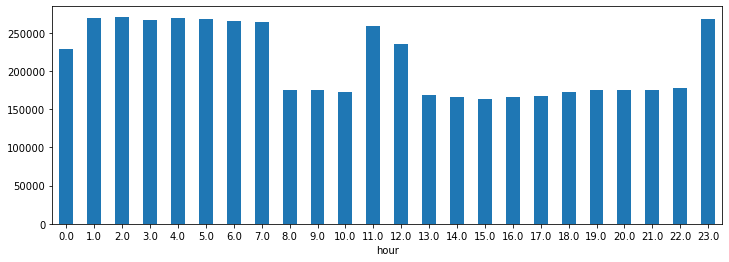

In [211]:
# initialise chart 
fig, axs = plt.subplots(figsize=(12, 4))

# we first drop duplicates if any 
datasetCopy = datasetCopy.drop_duplicates(['lastUpdated','name'],keep= 'last')

datasetCopy.groupby(datasetCopy["hour"])["bikes"].sum().plot(
    kind='bar', rot=0, ax=axs
)

If we observe above graph, we can find out that most bikes are available between 12AM to 8 AM. 

From 8 AM onwards we can see sudden drop in available bikes. 

So we can conclude that people starts their day around 7 - 8 AM. 

Around 11 AM -12 PM, we see sudden increase in available bikes. This can be due this this particular period of time is lunch time or people are taking pause during their work. 

From 5 PM onwards, again we see sudden increase in available bikes. This can be due to people are coming back from work. 

## Time series Analysis for some countries

In this section we did time series analysis for some of the countries

## Bikes use VS time period of day 

## Ireland

We first select data that has IE as a country code. For that we have written following piece of code. 

In [213]:
ieData = datasetCopy["country_code"]
ieData = datasetCopy.loc[datasetCopy['country_code'] == 'IE']

Now we plot a graph that has average bikes in use on Y axis and hour on  X axis

<AxesSubplot:xlabel='hour'>

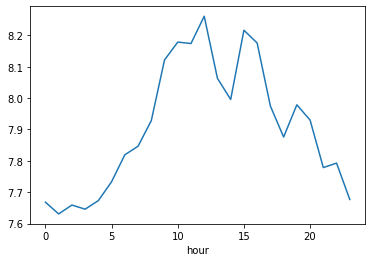

In [215]:
ieData.groupby(ieData["hour"])["bikesInUse"].mean().plot( )

#### From above graph, we can see that the bike use raises from around 5 AM which goes on till 11 AM. 
#### There is drop in use of bikes from 11 AM to 2 PM. Again it increases till 5 PM. After 5 PM we can see continous decrease in use of bikes. 

#### We can conclude below points from above observation - 
    - People in ireland starts their day around 5-6 AM and end theie day around 5 - 6PM. 
    - 11 AM - 2 PM might be lunch or relaxing time for peoples in ireland

## France

we do same analysis for france to find out if we can see any pattern

first step is to select data that has 'FR' as a country code. 

In [219]:
frData = datasetCopy.loc[datasetCopy['country_code'] == 'FR']

Now we plot a graph that has average bikes in use on Y axis and hour on  X axis

<AxesSubplot:xlabel='hour'>

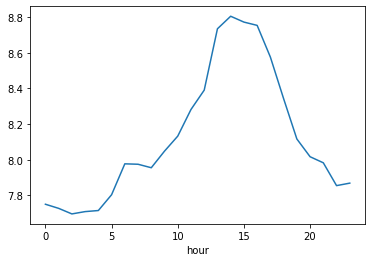

In [220]:
frData.groupby(frData["hour"])["bikesInUse"].mean().plot()

#### From above graph, we can see that the bike use raises from around 5 AM which goes on till 1 PM. 
#### After 4 PM we can see continous decrease in use of bikes. 

#### We can conclude below points from above observation - 
    - People in france starts their day around 5-6 AM and end their day around 4 - 5PM. 